# Imports and init constants

In [1]:
import torch
import torchvision
import torch.utils
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np

from torch.amp import autocast
from torch.utils.data import Dataset

In [2]:
!pip install lightning==2.5.0.post0
!pip install torchmetrics[image]
!pip install torch-fidelity

In [3]:
import lightning as L

from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch import Trainer, seed_everything

In [4]:
torch.cuda.is_available()

True

In [5]:
!rm -r /kaggle/working/reduce-mode-collapse-in-gan
!git clone https://github.com/ThViviani/reduce-mode-collapse-in-gan.git

import sys; sys.path.append('/kaggle/working/reduce-mode-collapse-in-gan')

Cloning into 'reduce-mode-collapse-in-gan'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 27 (delta 6), reused 21 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (27/27), 6.08 KiB | 6.08 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [ ]:
BACTH_SIZE = 256
LATENT_SPACE_DIM = 100
WANDB_TOKEN = '' # input your wandb token
PATH_TO_CHECKPOINT = ''
SEED = 999
MAX_EPOCHS = 20

seed_everything(SEED, workers=True)

INFO: Seed set to 999


999

In [7]:
import wandb

wandb.login(key=WANDB_TOKEN)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: developsviviani (developsviviani-clown-dev) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# Preparing MNIST

In [8]:
compose = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = torchvision.datasets.MNIST('MNIST/raw/train-images-idx3-ubyte', download=True, train=True, transform=compose)
val_dataset = torchvision.datasets.MNIST('MNIST/raw/train-images-idx3-ubyte', download=True, train=False, transform=compose)

In [9]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BACTH_SIZE, shuffle=True, num_workers=3)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=BACTH_SIZE, shuffle=False, num_workers=3)

# Networks

In [10]:
class GeneratorCNNBlock(nn.Module):
    """Defines a generator CNN block"""

    def __init__(self, in_channels, out_channels, activation="relu", use_dropout=False, norm_layer=nn.BatchNorm2d, **kwargs):
        """Construct a generator CNN block
        Parameters:
            in_channels (int)            -- the num
        |ber of channels in the input 
            out_channels (int)           -- the number of channels in the ouput when applyed this block
            activation (str)             -- the name of activation function: relu | another names
            use_dropout (bool)           -- if the flag is True then will add nn.Dropout after conv layer
            norm_layer (torch.nn)        -- normalization layer   
        """

        super(GeneratorCNNBlock, self).__init__()
        
        kernel_size    = kwargs.get("kernel_size", 4)
        stride         = kwargs.get("stride", 2)
        padding        = kwargs.get("padding", 1)
        output_padding = kwargs.get("output_padding", 0)
        padding_mode   = kwargs.get("padding_mode", "zeros")
        
        use_bias = True if norm_layer == nn.InstanceNorm2d else False

        activation_module = None
        if activation == "relu":
            activation_module = nn.ReLU(inplace=True)
        elif activation == "identity":
            activation_module = nn.Identity()
        else:
            activation_module = nn.LeakyReLU(0.2)

        self.conv = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, 
                out_channels, 
                kernel_size, 
                stride, 
                padding, 
                bias=use_bias, 
                output_padding=output_padding
            ),
            norm_layer(out_channels),
            activation_module, 
        )
        
        if use_dropout:
            self.conv.append(nn.Dropout(0.5))
    
    def forward(self, x):
        return self.conv(x)


In [11]:
class BaseGenerator(nn.Module):
    def __init__(self, ngf=64, nc=1):
        super().__init__()
        
        self.generator = nn.Sequential(
            GeneratorCNNBlock(LATENT_SPACE_DIM, ngf * 4, kernel_size=3, stride=2, padding=0), # (ngf * 4) x 3 x 3
            GeneratorCNNBlock(ngf * 4, ngf * 2, kernel_size=3, stride=2, padding=0), # (ngf * 2) x 8 x 8
            GeneratorCNNBlock(ngf * 2, ngf, kernel_size=3, stride=2, padding=0), # (ngf * ) x 16 x 16
            nn.ConvTranspose2d(ngf, nc, 3, 2, 2, 1), # nc x 28 x 88
            nn.Tanh()
        )
    
    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        return self.generator(z)

In [12]:
class DiscriminatorCNNBlock(nn.Module):
    """Defines a discriminator CNN block"""

    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, use_dropout=False, norm_layer=nn.BatchNorm2d):
        """Construct a convolutional block.
        Parameters:
            in_channels (int)  -- the number of channels in the input 
            out_channels (int) -- the number of channels in the ouput when applyed this block
            norm_layer         -- normalization layer 
            stride (int)       -- the stride of conv layer
        """

        super(DiscriminatorCNNBlock, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=1, bias=False),
            norm_layer(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

        if use_dropout:
            self.conv.append(nn.Dropout(0.3))
        
    def forward(self, x):
        return self.conv(x)

In [13]:
class BaseCritic(nn.Module):
    def __init__(self, ndf=28, nc=1):
        """Construct a base Critic.
        Parameters:
            ndf (int) -- Size of feature maps in discriminator
            nc (int) -- Number of input channels.
        """
        super().__init__()

        self.critic = nn.Sequential( # 1 x 28 x 28
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False), # 28 x 14 x 14
            nn.LeakyReLU(0.2, inplace=True), 
            DiscriminatorCNNBlock(ndf, ndf * 2), # 56 x 7 x 7
            DiscriminatorCNNBlock(ndf * 2, ndf * 4), # 112 x 3 x 3
            nn.Conv2d(ndf * 4, 1, 4, 2, 1, bias=False), # 1 x 1 x 1
        )
    
    def forward(self, x):
        return self.critic(x)

In [14]:
g = BaseGenerator()
print(g(torch.randn((BACTH_SIZE, LATENT_SPACE_DIM))).shape)

critic = BaseCritic()
b = next(iter(train_loader))
critic(b[0]).shape

torch.Size([256, 1, 28, 28])


torch.Size([256, 1, 1, 1])

# Experiments

In [15]:
class GeneratorForFIDWrapper(nn.Module):
    """A wrapper which transforms generator's images from [-1, 1] to [0, 255] and [B, 1, H, W] -> [B, 3, H, W]"""
    
    def __init__(self, generator, device, img_size=299):
        super().__init__()
        self.generator = generator
        self.img_size = img_size
        self.device = device 
    
    def forward(self, z):
        with torch.no_grad():
            imgs = self.generator(z)  # [B, 1, H, W], float32, [-1, 1]
            imgs = (imgs + 1) / 2  # [-1, 1] → [0, 1]
            imgs = imgs * 255
            imgs = imgs.clamp(0, 255).to(torch.uint8)
            
            if imgs.shape[1] == 1:
                imgs = imgs.repeat(1, 3, 1, 1)  # [B, 1, H, W] → [B, 3, H, W]
                
        return imgs

class DatasetForFIDWrapper(Dataset):
    """A dataset wrapper which returns only images (without labels)"""
    def __init__(self, dataset_class, **kwargs):
        """
            Args:
                dataset_class: Dataset class to wrap (e.g., torchvision.datasets.MNIST)
                **kwargs: All arguments required to initialize the dataset_class
        """
        self.dataset = dataset_class(**kwargs)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, _ = self.dataset[idx]
        image = (image + 1) / 2  # [-1, 1] → [0, 1]
        image = image * 255
        image = image.clamp(0, 255).to(torch.uint8) # -> [0, 255]
        if image.shape[0] == 1:
            image = image.repeat(3, 1, 1)
        return image

In [16]:
import torch_fidelity

compose = transforms.Compose([
    transforms.ToTensor(),
])

test_ds = torch_fidelity.register_dataset(
    'test_dataset_', 
    lambda root, download: DatasetForFIDWrapper(torchvision.datasets.MNIST, root=root, download=download, train=False, transform=compose)
) 

In [17]:
def generate_some_examples(model, n=64):
    z = torch.randn(BACTH_SIZE, LATENT_SPACE_DIM, device=model.device)
    generated_imgs = model.generator(z).detach()

    # Create grid and display
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Generated Images")
    grid = vutils.make_grid(generated_imgs[:n], padding=2, normalize=True).cpu()
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.show();

In [18]:
from datetime import datetime

## Vanila GAN

In [19]:
from trainers.standard_gan import StandardGAN
from utils.train_options import TrainOptions

wandb_logger = WandbLogger(
    project='Experiments', 
    save_dir='',
    log_model=True,
      name='StandardGAN_' + str(datetime.now()) 
) 

trainer = L.Trainer(
    max_epochs=MAX_EPOCHS, 
    logger=wandb_logger, 
    deterministic=True,
    # precision="16-mixed"
)

vanila_gan = StandardGAN(critic=BaseCritic(), generator=BaseGenerator(), opt=TrainOptions())
trainer.fit(model=vanila_gan, train_dataloaders=train_loader, val_dataloaders=val_loader)
wandb.finish()

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type          | Params | Mode 
----------------------------------------------------
0 | critic    | BaseCritic    | 128 K  | train
1 | generator | BaseGenerator | 600 K  | train
----------------------------------------------------
728 K     Trainable params
0         Non-trainable params
728 K     Total params
2.914     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.


d_grads_mean,▆▄▃▃▄▃▃▁▂▃▄▇▄▄▃▄▄▄██▃▆▃▅▇▄▇▇▃▄▄▁▆▃▅▃▅▄▅▃
d_grads_std,▁▅▅▄▅▃█▇▄▄▃▆▄▄▄▄▄▄▅▄▆▆▆▆▃▄▄▄▅▅▄▅▅▃▂▅▃▃▄▆
epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
g_grads_mean,█▄▁▃▂▂▂▃▄▄▃▅▃▁▂▃▄▃▃▄▂▄▂▃▁▃▂▂▃▃▂▂▁▄▄▂▂▂▃▄
g_grads_std,▅▃▁▁▂▂▃▂▂▃▁▄▄▃▂▄▄▃▃▂▃▃▃▂▃▃▂▄▂▃▅▃▆▅▅▆▄▃▄█
loss_d,▁▃▂▃▃█▅▃▇▃▄▃▄▄▄▄▅▅▃▄▃▅▃▄▅▆▃▅▃▅▃▄▃▃▄▃▄▄▄▃
loss_g,█▅▅▄▅▇▂▅▃▄▂▃▁▅▆▂▅▂▂▄▆▃▃▅▂▂▃▇▃▅▃▃▅▂▄▅▄▅▁▂
trainer/global_step,▁▁▁▂▂▂▂▃▃▁▃▄▄▄▄▄▄▅▁▅▅▅▁▅▁▆▁▆▆▇▁▇▁▇▇▇▁███
d_grads_mean,-0.01559
d_grads_std,0.47684
epoch,19


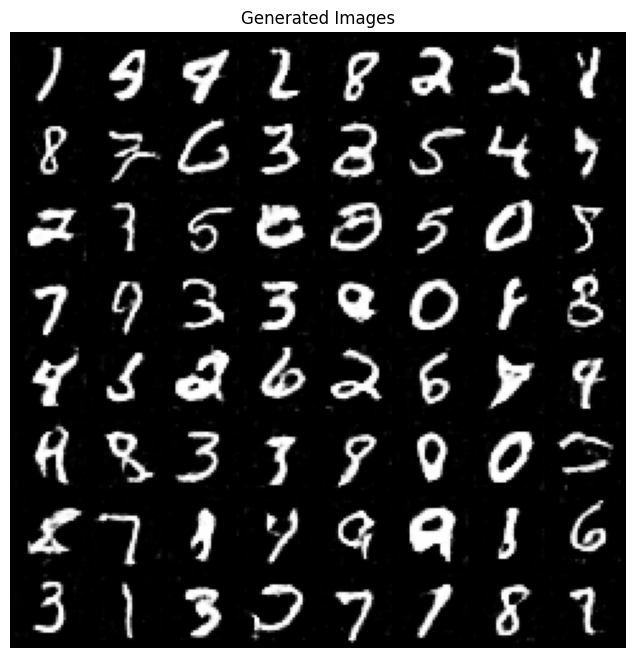

In [20]:
generate_some_examples(vanila_gan)

In [21]:
vanila_generator = GeneratorForFIDWrapper(vanila_gan.generator, vanila_gan.device)
wrapped_vanila_g = torch_fidelity.GenerativeModelModuleWrapper(vanila_generator, LATENT_SPACE_DIM, 'normal', 0)

metrics_dict_for_vanila = torch_fidelity.calculate_metrics(
    input1=wrapped_vanila_g,
    input2='test_dataset_',
    input1_model_num_samples=10000,
    input2_model_num_samples=10000,
    cuda=True,
    isc=True,
    fid=True,
    verbose=False,
    input2_root='MNIST/raw/train-images-idx3-ubyte',
    datasets_download=True,
    rng_seed=SEED,
)

print(metrics_dict_for_vanila)
del vanila_generator
del wrapped_vanila_g 
del vanila_gan
del trainer
del wandb_logger

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:01<00:00, 66.3MB/s]


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 6.08MB/s]


Extracting /root/.cache/torch/fidelity_datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/.cache/torch/fidelity_datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]


Extracting /root/.cache/torch/fidelity_datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.cache/torch/fidelity_datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]


Extracting /root/.cache/torch/fidelity_datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.cache/torch/fidelity_datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.66MB/s]

Extracting /root/.cache/torch/fidelity_datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.cache/torch/fidelity_datasets/MNIST/raw



{'inception_score_mean': 2.126542154768232, 'inception_score_std': 0.033591044429305016, 'frechet_inception_distance': 59.60424358314148}


## RpGAN

In [22]:
from trainers.rp_gan import RpGAN
from utils.train_options import TrainOptions

wandb_logger = WandbLogger(
    project='Experiments', 
    save_dir='',
    log_model=True,
    name='RpGAN_' + str(datetime.now())
) 

trainer = L.Trainer(
    max_epochs=MAX_EPOCHS, 
    logger=wandb_logger, 
    deterministic=True,
    # precision="16-mixed"
)

rp_gan = RpGAN(
    critic=BaseCritic(), 
    generator=BaseGenerator(), 
    opt=TrainOptions()
)

trainer.fit(model=rp_gan, train_dataloaders=train_loader, val_dataloaders=val_loader)
wandb.finish()

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type          | Params | Mode 
----------------------------------------------------
0 | critic    | BaseCritic    | 128 K  | train
1 | generator | BaseGenerator | 600 K  | train
----------------------------------------------------
728 K     Trainable params
0         Non-trainable params
728 K     Total params
2.914     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.


d_grads_mean,▆▅▅▆▆▆▆▇▆▄▅▆▆▅▆▆▇▅▆▃█▇█▇▆▅▆▆▅▇▃▆▄▄▆▅▅▄▁▇
d_grads_std,▁▂▂▂▂▃▃▃▁▂▃▂▂▂▃▂▂▄▂▅▃▁▄▃█▂▂▅▄▅▃▂▄▃▆▃█▆▃▅
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇▇████
g_grads_mean,▃▄▄▄▄▄▃▄▄▃█▆▆▆▄▅▃▄▃▁▅▃▅▃▃▂▂▂▇█▃▃▃▃▇▆▄▁▄▂
g_grads_std,▂▂▁▂▂▂▃▂▃▃▃▃▃▄▄▃▄▃▄▄▅▄▅▆▆▅▆▅▇▇▅▅▆▆▇▃▅▅▇█
loss_d,▁▁▁▁▂▂▁▁▁▁▁▁▁▂▁▁▄▁▁▁▁▁▂▁█▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁
loss_g,▃▅▇███▇█▆▅▄▄▅▂▄▅▄▅▅▅▂▄▆▄▃▅▄▆▄▅▄▂▅▄▁▃▄▃▄▃
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▁▃▃▃▃▄▄▁▄▅▅▅▆▆▆▇▇▇▇▇▇▁▇▇██▁█▁
d_grads_mean,-0.00962
d_grads_std,0.57504
epoch,19


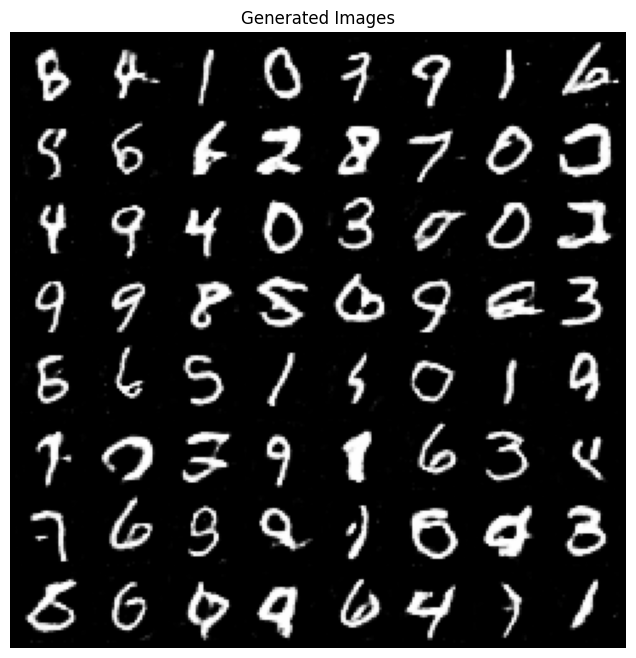

In [23]:
generate_some_examples(rp_gan)

In [24]:
rp_generator = GeneratorForFIDWrapper(rp_gan.generator, rp_gan.device)
wrapped_rp_g = torch_fidelity.GenerativeModelModuleWrapper(rp_generator, LATENT_SPACE_DIM, 'normal', 0)

metrics_dict_for_rp = torch_fidelity.calculate_metrics(
    input1=wrapped_rp_g,
    input2='test_dataset_',
    input1_model_num_samples=10000,
    input2_model_num_samples=10000,
    cuda=True,
    isc=True,
    fid=True,
    verbose=False,
    input2_root='MNIST/raw/train-images-idx3-ubyte',
    datasets_download=True,
    rng_seed=SEED,
)

print(metrics_dict_for_rp)
del rp_generator
del wrapped_rp_g 
del rp_gan
del trainer
del wandb_logger

/usr/local/lib/python3.11/dist-packages/torch_fidelity/utils.py:328: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  out[n] = torch.load(p, map_location='cpu')
/usr/local/lib/

{'inception_score_mean': 2.1245182412451515, 'inception_score_std': 0.025097525135724143, 'frechet_inception_distance': 45.93120340715848}


## RpGAN + R1, R2 grads penalties

In [25]:
from trainers.rp_gan import RpGAN
from utils.train_options import TrainOptions

wandb_logger = WandbLogger(
    project='Experiments', 
    save_dir='',
    log_model=True,
    name='RpGAN_R1R2_' + str(datetime.now())
) 

trainer = L.Trainer(
    max_epochs=MAX_EPOCHS, 
    logger=wandb_logger, 
    deterministic=True,
    # precision="16-mixed"
)

rpr1r2_gan = RpGAN(
    critic=BaseCritic(), 
    generator=BaseGenerator(), 
    opt=TrainOptions(), 
    use_r1r2_penalty=True
)
trainer.fit(model=rpr1r2_gan, train_dataloaders=train_loader, val_dataloaders=val_loader)
wandb.finish()

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type          | Params | Mode 
----------------------------------------------------
0 | critic    | BaseCritic    | 128 K  | train
1 | generator | BaseGenerator | 600 K  | train
----------------------------------------------------
728 K     Trainable params
0         Non-trainable params
728 K     Total params
2.914     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.


d_grads_mean,█▇▄▄▃▄▅▃▂▄▃▃▁▃▂▂▂▃▃▂▂▂▂▂▁▂▂▂▂▂▂▂▂▁▂▂▂▁▂▃
d_grads_std,█▆▄▅▆▃▄▅▄▃▅▃▄▅▄▄▄▃▃▄▃▂▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁
epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇██
g_grads_mean,▁█▄▃▃▅▃▃▃▃▃▃▃▃▄▄▃▃▃▃▄▃▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
g_grads_std,█▅▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_d,▁▂▆▅▆▆▇▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████▇██████████
loss_g,█▆▂▂▃▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▁▂▂▂▂▁▃▃▃▃▄▄▁▄▄▄▄▁▅▅▅▅▅▆▁▆▇▁▇▇▇▇███
d_grads_mean,8e-05
d_grads_std,0.00434
epoch,19


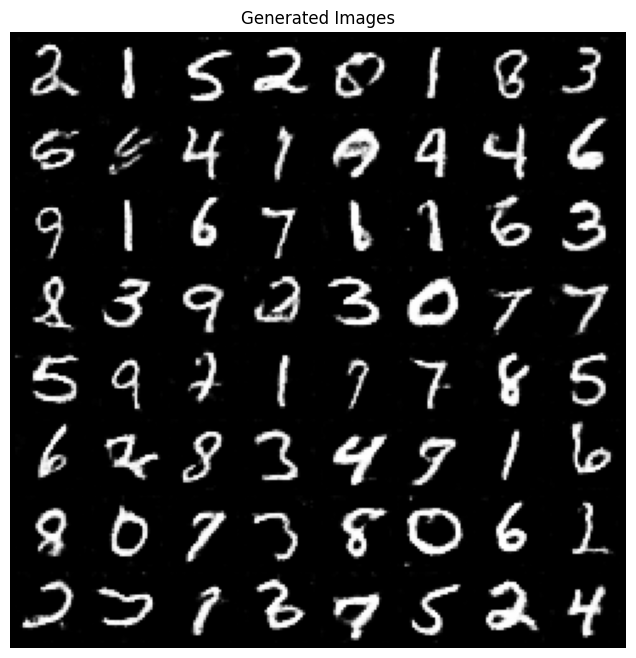

In [26]:
generate_some_examples(rpr1r2_gan)

In [27]:
rpr1r2_g = GeneratorForFIDWrapper(rpr1r2_gan.generator, rpr1r2_gan.device)
wrapped_rp_penalty_g = torch_fidelity.GenerativeModelModuleWrapper(rpr1r2_g, LATENT_SPACE_DIM, 'normal', 0)

metrics_dict_for_rp_with_penalty = torch_fidelity.calculate_metrics(
    input1=wrapped_rp_penalty_g,
    input2='test_dataset_',
    input1_model_num_samples=10000,
    input2_model_num_samples=10000,
    cuda=True,
    isc=True,
    fid=True,
    verbose=False,
    input2_root='MNIST/raw/train-images-idx3-ubyte',
    datasets_download=True,
    rng_seed=SEED,
)

print(metrics_dict_for_rp_with_penalty)
del rpr1r2_g
del wrapped_rp_penalty_g 
del rpr1r2_gan
del trainer
del wandb_logger

{'inception_score_mean': 2.1353616574013414, 'inception_score_std': 0.030110080804740036, 'frechet_inception_distance': 36.54002819422698}
